In [2]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
import pandas as pd
import math
import scipy
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rc
from matplotlib.patches import Rectangle
import seaborn.apionly as sns
from IPython.display import HTML
import os, glob, sys
import warnings
warnings.simplefilter('always')

from bokeh.server.server import Server
from bokeh.application import Application
from bokeh.application.handlers.function import FunctionHandler
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models.sources import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from bokeh.layouts import gridplot

/home/mkhoshle/miniconda3/envs/research/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
np.seterr(all='raise', divide='ignore', over='raise', under='ignore', invalid='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

#### Load Generated Synthetic Data

In [4]:
data = pd.read_csv('observation.csv')
data = data.drop(['Unnamed: 0'],axis=1)

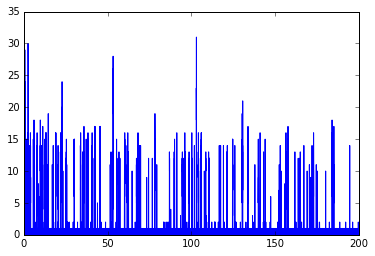

In [5]:
%matplotlib inline
plt.plot(data['0'],data['1'])

N is Number of time levels and is obtained from the length of observations

In [49]:
Wn = np.array(data['1'])
N = len(Wn)  

In [50]:
class FFBS:
    def emission_distribution(self,x,Sn,params,M,ID,Snm):
        # This is needed for the calculation of the Filter
        ind = list(range(M))
        ind.remove(ID)
        self.Ksn = np.where(Sn==1,params['k_sigma2'],0.0) # Ksn[M,N]
        self.Ksn_filter = [0.0,params['k_sigma2'],0.0,0.0,0.0,params['k_sigma2'],0.0,0.0] # Ksn_filter[8]
        #self.rate [8,N]
        self.rate = [params['theta']*(params['rho']+np.dot(params['bm'][0,ind],self.Ksn[ind,:])+self.Ksn_filter[i])*hyper_param['dt'] for i in range(2)]   
        likelihood = [-self.rate[0]+x*np.log(self.rate[0]),-self.rate[1]+x*np.log(self.rate[1])]
        
        d = []
        d.append(likelihood)
        for i in range(6):
            d.append(likelihood[0])         
        
        return np.vstack(d)
    
    # Filter changes for each particle because of the change in the rates. But transition matrix is the same.
    def Filter(self,pi,pi_filter,N,ID,Sn,Snm,Wn,M,params,hyper_param):  
        A = np.zeros([8,N], dtype=np.float64)
        A_star = np.zeros([8], dtype=np.float64)
        # Likelihood or Emission distribution
        F = self.emission_distribution(Wn,Sn,params,M,ID,Snm)      # F[8,N]
        
        p1 = hyper_param['gama']/(hyper_param['gama']+M-1)
        pi0 = np.array([p1,0,0,0,1-p1,0,0,0])   # pi0[8,1] 
#         A_star = pi0*F[:,0]
#         c1 = np.sum(A_star)
#         A[:,0] = A_star[:]/c1  # Array of 8*N where 8 is the number of possible states for the filter 
        
        A[:,0] = pi0
        for i in range(1,N):
            d = F[:,i]+np.log(np.dot(np.transpose(pi_filter),A[:,i-1]))
            MM = -np.maximum.reduce(d)
            A_star = np.exp(d+MM)
            c1 = np.sum(A_star)
            A[:,i] = A_star/c1
    
        return A
    
    def sample(self,weight):
        P = np.cumsum(weight)
        return np.searchsorted(P, np.random.uniform())
    
    def _FFBS(self,N,pi,pi_filter,params):
        # States of the system considered for the filter
        Snm = np.column_stack([[1,1,1,1,0,0,0,0],[0,1,2,3,0,1,2,3]]) #Snm[8,2]
        bm = np.zeros([1,M],dtype=int) 
        for ID in range(M):      
            A = self.Filter(pi,pi_filter,N,ID,Sn,Snm,Wn,M,params,hyper_param) # A[8,N]
            # Sanity Check
            if np.sum(A,axis=0).all()==1:
                pass
            else:
                raise Exception('Filter is not working for ID{} with {}'.format(ID,np.sum(A,axis=0)))
             
            ind_N = np.random.choice(8,p=A[:,N-1])  # Get the state at the last time level
            Sn.iloc[ID,N-1] = Snm[ind_N,1]
            bm[0,ID] = Snm[ind_N,0]
            AA = A[:4,:] if ind_N<4 else A[4:,:]    # AA[4,N]
            
            for n in range(N-2,-1,-1):
                weight = AA[:,n]*pi[:,Sn.iloc[ID,n+1]]
                weight /= np.sum(weight)
                Sn.iloc[ID,n] = self.sample(weight)
          
        return Sn
#         return bm, Sn

In [51]:
class Metropolis_Hastings:
    def __init__(self,alfa1,alfa2):
        self.alfa1 = alfa1
        self.alfa2 = alfa2
        
    def _proposal(self,x,alfa):
        return np.random.gamma(alfa,scale=x/alfa) 
    
    def sample(self,rho_old,k_sigma2_old):
        rho_prop = self._proposal(rho_old,self.alfa1) 
        k_sigma2_prop = self._proposal(k_sigma2_old,self.alfa2)
        return rho_prop, k_sigma2_prop
    
    def _proposal_pdf(self,x1,x2,alfa):
        return ((2*alfa-1)*(np.log(x1)-np.log(x2))+alfa*(x2/x1-x1/x2))
    
    def _prior(self,x1,x2,alfa,beta):
        return (alfa-1)*(np.log(x2)-np.log(x1))+(x1-x2)/beta
    
    def _likelihood(self,x1,y1,x2,y2,Sn,params,hyper_param,Wn):
        Ksn1 = np.where(Sn==1,y1,0.0)
        rate1 = params['theta']*(x1+np.dot(params['bm'],Ksn1))*hyper_param['dt'] 
        
        Ksn2 = np.where(Sn==1,y2,0.0)
        rate2 = params['theta']*(x2+np.dot(params['bm'],Ksn2))*hyper_param['dt'] 

        return np.sum(Wn*(np.log(rate1)-np.log(rate2))+(rate2-rate1))
    
    def Acceptance_ratio(self,params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn):        
        # Calculated the log of Prior_ratio, Proposal_ratio, and Likelihood_ratio
        prior_ratio = (self._prior(rho_old,rho_prop,hyper_param['alfa1_prior'],hyper_param['beta1'])+
                       self._prior(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_prior'],hyper_param['beta2']))         
        
        proposal_ratio = (self._proposal_pdf(rho_old,rho_prop,self.alfa1)+
                          self._proposal_pdf(k_sigma2_old,k_sigma2_prop,self.alfa2))
        
        likelihood_ratio = self._likelihood(rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Sn,params,hyper_param,Wn) 
        
        return likelihood_ratio+prior_ratio+proposal_ratio

In [52]:
class Gibbs_sampler:  
    def update_theta(self,alfa,beta,Wn,Ksn,params):
        alfa_new = alfa+np.sum(Wn)
        beta_new = beta+np.sum((params['rho']+np.dot(params['bm'],Ksn))*hyper_param['dt'])
        
        return np.random.gamma(alfa_new,1./beta_new)
    
    def update_roh_ksigma2(self,params,repeats,accepted):
        MH = Metropolis_Hastings(hyper_param['alfa1_proposal'],hyper_param['alfa2_proposal'])
        rho_old = params['rho']
        k_sigma2_old = params['k_sigma2']
        
        # Step (a)
        rho_prop,k_sigma2_prop = MH.sample(rho_old,k_sigma2_old)
        # Step (b)
        AR = MH.Acceptance_ratio(params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn)
        # Step (c)
        v = np.random.exponential(scale=1)
        # Step (d)
        if v>-AR:
            accepted = accepted + 1.0
            return rho_prop, k_sigma2_prop, accepted
        else:
            return rho_old, k_sigma2_old, accepted 
            
    def update_pi(self,Sn):
        # total number of transitions for all particles over time 
        # is M*(N-1)
        count = dict({0:{0:0,1:0,2:0,3:0},1:{0:0,1:0,2:0,3:0},
                      2:{0:0,1:0,2:0,3:0},3:{0:0,1:0,2:0,3:0}})
        for j in range(M):
            for i in range(N-1):
                state1 = Sn.iloc[j,i]
                if Sn.iloc[j,i+1]==0:
                    count[state1][0] += 1
                elif Sn.iloc[j,i+1]==1:
                    count[state1][1] += 1
                elif Sn.iloc[j,i+1]==2:
                    count[state1][2] += 1
                elif Sn.iloc[j,i+1]==3:
                    count[state1][3] += 1
                    
        if count[0][1]>1:
            raise Exception('Wrong transitions are happening')
            
        return count

    def update_weight_State(self,hyper_param,pi,pi_filter,params):
        ffbs = FFBS()
        return ffbs._FFBS(N,pi,pi_filter,params)

In [53]:
def update_pi_filter(pi):
    aa = np.zeros([4,4],dtype=np.float64)
    d1 = np.column_stack([pi,aa])
    d2 = np.column_stack([aa,pi])
    return np.vstack([d1,d2])

In [54]:
def __main__(repeats,M,pi,Sn,Ksn,pl):
    data1 = 'Wn.h5'
    data2 = 'params.h5'
    
    data = dict({'theta': [],'rho': [],'k_sigma2': [],'B':[], 'ite':[],'E_b':[],'E_ph':[]})

    gibbs = Gibbs_sampler()
    accepted  = 0.0
    p = pd.DataFrame()
    for j in range(repeats):
        print(j)
        start1 =  time.time()
        params['theta'] = gibbs.update_theta(hyper_param['alfa'],hyper_param['beta'],Wn,Ksn,params)
        # Metropolis Hastings
        params['rho'], params['k_sigma2'], accepted = gibbs.update_roh_ksigma2(params,repeats,accepted)
        # Update Transition Probabilities
        count = gibbs.update_pi(Sn)

        state = 0 
        pi[0] = np.array(list(np.random.dirichlet((0.7+count[state][0],0.3+count[state][1])))+[0,0])
        state = 1
        pi[1] = np.array([0]+list(np.random.dirichlet((0.25+count[state][1],0.25+count[state][2],0.2+count[state][3]))))
        state = 2 
        pi[2] = np.array([0]+list(np.random.dirichlet((0.4+count[state][1],0.6+count[state][2])))+[0])
        pi[3] = np.array([0,0,0,1])
        
        pi_filter = update_pi_filter(pi)
        p = pd.concat([p,pd.DataFrame(pi)],axis=0)
        
        # Sanity Check
        if all(np.sum(pi,axis=1))==1 and all(np.sum(pi_filter,axis=1))==1:
            pass
        else:
            raise Exception('probabilities do not sum to 1')      
        print(params['theta'],params['rho'],params['k_sigma2'])
        
        # FFBS
#         params['bm'], Sn = gibbs.update_weight_State(hyper_param,pi,pi_filter,params)
        Sn = gibbs.update_weight_State(hyper_param,pi,pi_filter,params)

        # Sanity Check
        if all(Sn.iloc[:,0])==0:
            pass
        else:
            raise Exception('The initial state of the particle is not zero')
            
        # Store the Date
        data['theta'].append(params['theta'])
        data['rho'].append(params['rho'])
        data['k_sigma2'].append(params['k_sigma2'])  
        data['E_b'].append(params['theta']*params['rho'])
        data['E_ph'].append(params['theta']*params['k_sigma2'])
#         data['B'].append(np.count_nonzero(params['bm']))      
        data['ite'].append(j)
    
        # Timing
        start2 = time.time()
        print(start2-start1,accepted)
#         print(start2-start1,np.count_nonzero(params['bm']),accepted)

        # Save the output
        df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in data.items()]))
        params_data = pd.HDFStore(data2)
        params_data['df{}'.format(j)] = df.loc[j]
        params_data.close()
        
        Ksn = np.where(Sn==1,params['k_sigma2'],0.0)
        estimated_emission = params['theta']*(params['rho']+np.dot(params['bm'],Ksn))*hyper_param['dt']
        estimated_emission_final = pd.DataFrame(dict({'ite':range(N),'est':estimated_emission.reshape(N,)}))
        
        emission_data = pd.HDFStore(data1)
        emission_data['df{}'.format(j)] = pd.DataFrame(estimated_emission)
        emission_data.close()
        
        # Some postprocessing
#         new_data = dict({'theta': [params['theta']],'rho': [params['rho']],
#                          'k_sigma2': [params['k_sigma2']],'B':[np.count_nonzero(params['bm'])],'ite':[j]})
#         plot_traces(estimated_emission_final,new_data,pl)
    
    # Calculate Acceptance Rate
    Acceptance_rate = accepted/repeats
    print ("Acceptance rate = " + str(Acceptance_rate*100))
    
    return data, Acceptance_rate, p

#### Hyper-parameters:
dt is the exposure time, alfa & beta are hyper-parameters of Theta, alfa1 & beta1 are hyper-parameters of Rho,
alfa2 & beta2 are hyper-parameters of K_sigma2

In [55]:
repeats = 5000

In [56]:
hyper_param = {'alfa':1.0,'beta':1.0,'alfa1_proposal':1500,'beta1':1.0,'alfa1_prior':1.0,'alfa2_prior':1.0,
               'alfa2_proposal':1500,'beta2':1.0,'N_particles':1,'gama':1.0, 
               'dt':0.01*.95} 

In [57]:
M = hyper_param['N_particles']

#### Parameters to be calculated by Gibbs Sampler 

In [58]:
params = {'theta':1e+3,
          'rho':0.01,
          'k_sigma2':1,
          'bm':np.ones((1,M),dtype=int)}  # bm[1,M]

#### Note: 
The weights for the transition probability distribution are our hyper-parameters and we assume them.

In [59]:
pi0 = np.array(list(np.random.dirichlet((0.7,0.3)))+[0,0])
pi1 = np.array([0]+list(np.random.dirichlet((0.55,0.25,0.2))))
pi2 = np.array([0]+list(np.random.dirichlet((0.4,0.6)))+[0])
pi3 = np.array([0,0,0,1])

In [60]:
pi = np.stack((pi0,pi1,pi2,pi3),axis=0)

In [61]:
pi

array([[8.75775239e-01, 1.24224761e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.99328061e-01, 4.46070347e-06, 6.67478632e-04],
       [0.00000000e+00, 8.36514068e-02, 9.16348593e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

#### Note: 
We know that the initial states of all particles is known and they are Inactive at the initial time level 

In [62]:
Sn = np.zeros([M,N],dtype=np.int)
Sn[:,0] = 0

In [63]:
# Note: Always double check to make sure wrong transitions are not happening, like more than one transition   
# from state zero to state one and from state one to state zero.
for i in range(M):
    for j in range(1,N):
        Sn[i,j] = np.random.choice(4,p=pi[Sn[i,j-1]])
Sn = pd.DataFrame(Sn)  #Sn[M,N]

In [64]:
Ksn = np.where(Sn==1,params['k_sigma2'],0.0)   # Ksn[M,N]

In [65]:
def plot_traces(estimated_emission_final,new_data,p):
    source.stream(new_data)
    source1.stream(estimated_emission_final)
#     doc.add_periodic_callback(__main__)
    handle = show(p, notebook_handle=True)
    push_notebook(handle=handle)

In [ ]:
import time
from line_profiler import LineProfiler
if __name__ == '__main__':
    if os.path.isfile('Wn.h5'):
        os.remove('Wn.h5')
        os.remove('params.h5')
        
    source = ColumnDataSource({'theta': [],'rho': [],'k_sigma2': [],'B':[],'ite':[]})
    s1 = figure(width=250, plot_height=250, title=None)
    s1.line(x='ite', y='theta', line_width=3, color="navy", alpha=0.5, source=source)

    s2 = figure(width=250, height=250, title=None)
    s2.line(x='ite', y='rho', line_width=3, color="firebrick", alpha=0.5, source=source)

    s3 = figure(width=350, height=250, title=None)
    s3.line(x='ite', y='k_sigma2', line_width=3, color="olive", alpha=0.5, source=source)

    s4 = figure(width=250, height=250, title=None)
    s4.line(x='ite', y='B', line_width=3, color="black", alpha=0.5, source=source)
    
    source1 = ColumnDataSource(pd.DataFrame(columns=['ite','est']))
    s5 = figure(width=350, height=250, title=None)
    s5.line(x='ite', y='est', line_width=3, color="black", alpha=0.5, source=source1)
    s5.line(range(N), Wn, line_width=3, color="blue", alpha=0.5)
    
    pl = gridplot([[s1,s2,s3],[s4,s5]], toolbar_location=None)
    
#     s1.add_tools(ResetTool(reset_size=False),PanTool(dimensions="width"),
#                  WheelZoomTool(dimensions="width"))
#     doc.add_root(p)
    
    out = __main__(repeats,M,pi,Sn,Ksn,pl) 
    # Use line-profiler for optimization
#     lp = LineProfiler()
#     lp.add_function(FFBS._FFSB)
#     lp_wrapper = lp(__main__)
#     lp_wrapper(repeats,M,pi,Sn,Ksn)
#     lp.print_stats()
#------------------------------------------------------
#     %lprun -f __main__  __main__(repeats,M,pi,Sn,Ksn) 

0
542.0580019125123 0.01 1
5.717501163482666 0.0
1
948.9911771063979 0.01 1
5.795407295227051 0.0
2
964.8196605564982 0.01 1
5.764300584793091 0.0
3
981.5149403100705 0.009597513893953535 1.0377107783755108
5.814397811889648 1.0
4
948.4093275094967 0.009542717621096715 1.06387811527148
5.973349094390869 2.0
5
922.62079839697 0.009809138576486038 1.0700253524750616
5.645055055618286 3.0
6
922.8894838168688 0.009809138576486038 1.0700253524750616
5.8133385181427 3.0
7
910.7857314881777 0.009662758504045096 1.0924040697414166
5.611008405685425 4.0
8
907.9569222788278 0.009733507237806329 1.1024397275134719
5.630626916885376 5.0
9
900.1296826227193 0.009733507237806329 1.1024397275134719
5.63236141204834 5.0
10
886.4006515028093 0.009818918616115219 1.1039104687686818
5.735845565795898 6.0
11
895.6876085538817 0.009818918616115219 1.1039104687686818
5.783662557601929 6.0
12
897.6917573572695 0.009818918616115219 1.1039104687686818
5.702816963195801 6.0
13
897.097434594571 0.009818918616115

528.4524377636645 0.015474287220957457 1.9217678099344688
5.575024604797363 43.0
101
533.5935708380435 0.015395208935596186 1.949267685171106
5.6055357456207275 44.0
102
522.0882419589125 0.015446204998629238 1.9613048792104248
5.637168645858765 45.0
103
521.4571926317386 0.015770681360235746 1.9699243494749084
5.789949893951416 46.0
104
518.0274857502217 0.016274114612063625 1.9753591518761329
5.6335577964782715 47.0
105
520.8923170145313 0.0171281371463266 2.075557469363965
5.56833028793335 48.0
106
494.68636849958796 0.0171281371463266 2.075557469363965
5.853494644165039 48.0
107
495.8309664622537 0.0171281371463266 2.075557469363965
5.792006731033325 48.0
108
498.3080896931614 0.0171281371463266 2.075557469363965
5.654484510421753 48.0
109
494.8821460093471 0.0171281371463266 2.075557469363965
5.613082408905029 48.0
110
489.0635427543731 0.0171281371463266 2.075557469363965
5.634753465652466 48.0
111
491.19431138178663 0.0171281371463266 2.075557469363965
5.651170969009399 48.0
112

5.572840452194214 71.0
198
340.6458556661973 0.02813772177466478 2.999690422950358
5.651597023010254 71.0
199
341.1259499911433 0.02813772177466478 2.999690422950358
5.610976696014404 71.0
200
343.5847030200461 0.02813772177466478 2.999690422950358
5.8714447021484375 71.0
201
338.11545604766553 0.02912012728562006 3.032318054097918
5.663578033447266 72.0
202
333.74642179543247 0.02912012728562006 3.032318054097918
5.656837463378906 72.0
203
336.5368200354611 0.029223221146861166 3.097476383620596
5.643366813659668 73.0
204
332.2542532169636 0.029223221146861166 3.097476383620596
5.610097646713257 73.0
205
330.1548738348156 0.029223221146861166 3.097476383620596
5.54046106338501 73.0
206
327.0238465929325 0.029223221146861166 3.097476383620596
5.611557960510254 73.0
207
329.7762723077985 0.029223221146861166 3.097476383620596
5.936542987823486 73.0
208
332.5650226483257 0.029223221146861166 3.097476383620596
5.611782789230347 73.0
209
330.7591490889175 0.029738649689092827 3.10407854911

230.55053292905066 0.04410623450271893 4.525412723963876
5.60427451133728 109.0
296
225.61258664582593 0.04410623450271893 4.525412723963876
5.52821159362793 109.0
297
226.13665222204475 0.04410623450271893 4.525412723963876
5.532078504562378 109.0
298
223.98173647114024 0.044028634307443575 4.560163660939417
5.575801610946655 110.0
299
223.82228591108398 0.044028634307443575 4.560163660939417
5.975406169891357 110.0
300
222.57004349647096 0.04372759849962049 4.613256285515377
5.7667436599731445 111.0
301
222.30494439081085 0.04372759849962049 4.613256285515377
5.500443935394287 111.0
302
220.68302337841982 0.04301036563783457 4.739745013033829
5.783904552459717 112.0
303
216.03811922115108 0.04462886808974244 4.685111721450025
5.631245136260986 113.0
304
219.5403491423436 0.04462886808974244 4.685111721450025
5.626909017562866 113.0
305
216.95355690831144 0.045310750580691936 4.746965617459041
5.64277458190918 114.0
306
217.13184524070718 0.04572095343523503 4.729349172624394
5.684405

5.5913872718811035 143.0
392
174.28095001846356 0.05697804528420644 5.8890531879320855
5.855581760406494 143.0
393
172.7573236420133 0.058844392630910916 6.162256480895978
5.6862874031066895 144.0
394
168.13604377295474 0.058844392630910916 6.162256480895978
5.822511434555054 144.0
395
166.22942580922413 0.058556368077554787 6.181750381147783
6.025161504745483 145.0
396
165.64901515012207 0.060477358244734505 6.1632179100091875
5.913597345352173 146.0
397
167.32833788401467 0.060477358244734505 6.1632179100091875
5.4913551807403564 146.0
398
165.52794343931774 0.060477358244734505 6.1632179100091875
5.573543548583984 146.0
399
168.97983964397275 0.060477358244734505 6.1632179100091875
5.580654144287109 146.0
400
167.29948770936718 0.060477358244734505 6.1632179100091875
5.8360772132873535 146.0
401
168.4395565050542 0.060477358244734505 6.1632179100091875
5.783673048019409 146.0
402
165.20646853848172 0.060477358244734505 6.1632179100091875
5.789310455322266 146.0
403
168.2907121802924

5.597984075546265 183.0
489
132.3116509916629 0.07433781319464756 7.79803358387805
5.519604444503784 183.0
490
132.49476035279923 0.0784097689219285 7.737302682354446
5.599133253097534 184.0
491
131.40079586501247 0.07653941564725844 7.80144074138135
5.798205137252808 185.0
492
132.35986282317344 0.07610719654977266 7.835774360208981
5.579869270324707 186.0
493
130.10829752668974 0.07467487313070463 7.900272471078352
5.577093839645386 187.0
494
130.0973891098016 0.07612829908205238 8.083508111916862
5.602428674697876 188.0
495
128.3581760081785 0.07705079095745207 8.119311723132979
5.691502332687378 189.0
496
126.37781899580214 0.07705079095745207 8.119311723132979
5.59987211227417 189.0
497
126.00549290627926 0.07623897578423408 8.114979691396373
5.551350355148315 190.0
498
127.9870962179649 0.07498909518877182 8.176677614623669
5.621645450592041 191.0
499
125.89329322186 0.07736029676347149 8.168740259350175
5.60428786277771 192.0
500
124.92356011119725 0.07736029676347149 8.16874025

5.6401941776275635 220.0
586
103.63593809944149 0.09482537175143392 10.017418231022138
5.662666320800781 221.0
587
104.89722957249792 0.09449947069527409 9.846458163705824
5.63692569732666 222.0
588
105.063660851795 0.09449947069527409 9.846458163705824
5.559841632843018 222.0
589
105.69785407634079 0.09449947069527409 9.846458163705824
5.5609681606292725 222.0
590
104.33019373553527 0.09449947069527409 9.846458163705824
5.63404393196106 222.0
591
104.00816981960841 0.09449947069527409 9.846458163705824
5.698224067687988 222.0
592
104.01861536476676 0.09449947069527409 9.846458163705824
5.5797014236450195 222.0
593
104.58922447539204 0.09129806891074309 9.809974941991937
5.569899797439575 223.0
594
105.61713602317072 0.09129806891074309 9.809974941991937
5.591509580612183 223.0
595
105.41070774093528 0.09129806891074309 9.809974941991937
5.582003831863403 223.0
596
106.31607779314677 0.09129806891074309 9.809974941991937
5.502497434616089 223.0
597
104.83820644155827 0.0912980689107430

5.656343698501587 250.0
683
94.97889034942038 0.10403448795871527 10.92632654821127
5.619716167449951 250.0
684
93.90189108551218 0.10534285961569143 11.202247368158577
5.552025556564331 251.0
685
92.89412718039088 0.10534285961569143 11.202247368158577
5.537315845489502 251.0
686
92.66754831508244 0.10534285961569143 11.202247368158577
5.587591886520386 251.0
687
91.1263326711026 0.10534285961569143 11.202247368158577
5.600045204162598 251.0
688
91.27210601994003 0.10534285961569143 11.202247368158577
5.548383951187134 251.0
689
91.97203416236597 0.10778831467077388 11.406004738807717
5.700555801391602 252.0
690
89.73856270679707 0.10778831467077388 11.406004738807717
5.685514211654663 252.0
691
91.05698476595693 0.10778831467077388 11.406004738807717
5.6796791553497314 252.0
692
90.33459438284648 0.10778831467077388 11.406004738807717
5.724916219711304 252.0
693
89.62426789163689 0.10778831467077388 11.406004738807717
5.662953615188599 252.0
694
91.86851386098448 0.10948543320487207 

82.17495490753522 0.1212022570892167 12.426250684577127
5.51459002494812 288.0
781
83.1729901957072 0.1212022570892167 12.426250684577127
5.5086448192596436 288.0
782
83.56292843148677 0.1212022570892167 12.426250684577127
5.647073268890381 288.0
783
81.59991764811042 0.1212022570892167 12.426250684577127
5.644139051437378 288.0
784
82.81139833974244 0.1212022570892167 12.426250684577127
5.704817533493042 288.0
785
83.41672655929673 0.1212022570892167 12.426250684577127
5.729333877563477 288.0
786
82.97110847847546 0.11708048315045606 12.495379531616253
5.782212734222412 289.0
787
82.51541524988869 0.11708048315045606 12.495379531616253
5.72220516204834 289.0
788
81.78612733823633 0.11708048315045606 12.495379531616253
5.633272647857666 289.0
789
83.14427284614405 0.11708048315045606 12.495379531616253
5.616540431976318 289.0
790
83.58354568836822 0.11708048315045606 12.495379531616253
5.636641025543213 289.0
791
83.3433419995177 0.11708048315045606 12.495379531616253
5.733089685440063

78.70249942662817 0.1331796613259661 13.217770024339366
5.6053385734558105 321.0
878
77.85958139943416 0.1331796613259661 13.217770024339366
5.649684906005859 321.0
879
76.9994162472438 0.1331796613259661 13.217770024339366
5.646193265914917 321.0
880
77.38888384958736 0.12718535563929084 13.40200008602385
5.62449836730957 322.0
881
76.3464394972253 0.12718535563929084 13.40200008602385
5.614682912826538 322.0
882
77.18076868524867 0.12718535563929084 13.40200008602385
5.70695424079895 322.0
883
77.96053254298572 0.12718535563929084 13.40200008602385
5.676290273666382 322.0
884
76.49586629382861 0.12718535563929084 13.40200008602385
5.621445178985596 322.0
885
77.11924402304311 0.12718535563929084 13.40200008602385
5.617566347122192 322.0
886
76.7568212355613 0.12718535563929084 13.40200008602385
5.657694578170776 322.0
887
77.39197354605898 0.12718535563929084 13.40200008602385
5.641867399215698 322.0
888
77.31631443908985 0.1253512591231392 13.531940493197528
5.6073899269104 323.0
88

5.666804075241089 355.0
975
72.0298643373182 0.14112113558127132 14.425847700098013
5.641342639923096 356.0
976
71.17406914418223 0.14112113558127132 14.425847700098013
5.541306734085083 356.0
977
70.87737994414817 0.14112113558127132 14.425847700098013
5.557721853256226 356.0
978
71.77469133490744 0.14112113558127132 14.425847700098013
5.6425621509552 356.0
979
71.11488560997573 0.1414374118918376 14.400063848510829
5.683382034301758 357.0
980
71.84918841931474 0.1414374118918376 14.400063848510829
5.66480278968811 357.0
981
70.83769481365346 0.14261746680762083 14.372341531007116
5.581504583358765 358.0
982
71.17999448790984 0.14261746680762083 14.372341531007116
5.611660957336426 358.0
983
71.58809095236684 0.13947772414483264 14.4645790975101
5.616508483886719 359.0
984
71.5271126770582 0.13981252912001446 14.493306305288108
5.531145811080933 360.0
985
71.48527094247214 0.14416895605938132 14.348163040809062
5.570315599441528 361.0
986
71.28855223098432 0.14416895605938132 14.34816

5.7059431076049805 380.0
1071
64.78905101746341 0.15412296803595046 15.928513308635434
5.762033939361572 380.0
1072
64.57418173476938 0.15412296803595046 15.928513308635434
5.688934326171875 380.0
1073
64.04269482927522 0.15637409373335046 16.17927022988956
5.587785482406616 381.0
1074
64.08304320881805 0.15637409373335046 16.17927022988956
5.677677631378174 381.0
1075
64.00028964712504 0.15637409373335046 16.17927022988956
5.702142238616943 381.0
1076
64.61768775846845 0.15637409373335046 16.17927022988956
5.622742176055908 381.0
1077
63.945501857391164 0.15962203561498106 16.301757253121213
5.65064263343811 382.0
1078
63.456541189329485 0.15962203561498106 16.301757253121213
5.775831699371338 382.0
1079
63.28687027954909 0.16282541055839087 16.15064603597834
5.710596084594727 383.0
1080
65.38731882972402 0.16282541055839087 16.15064603597834
5.620619297027588 383.0
1081
64.10056369081529 0.16282541055839087 16.15064603597834
5.673999786376953 383.0
1082
63.83254795970845 0.1628254105

5.704753637313843 413.0
1167
56.45548494033075 0.17581582090443404 18.198807818678386
5.6205384731292725 414.0
1168
56.570552070495275 0.17581582090443404 18.198807818678386
5.599217414855957 414.0
1169
56.71675719136485 0.17581582090443404 18.198807818678386
5.599501848220825 414.0
1170
56.53966467791408 0.1746283857432876 18.339601164723387
5.634701251983643 415.0
1171
56.76900390136348 0.17560859602424275 18.02572142610386
5.648196220397949 416.0
1172
57.137011761790475 0.17560859602424275 18.02572142610386
5.5689873695373535 416.0
1173
57.63097385098486 0.17560859602424275 18.02572142610386
5.506579399108887 416.0
1174
57.16879783905296 0.17560859602424275 18.02572142610386
5.6118083000183105 416.0
1175
57.60723350821626 0.17560859602424275 18.02572142610386
5.705453634262085 416.0
1176
57.59706864569341 0.17560859602424275 18.02572142610386
5.632640600204468 416.0
1177
57.35839781750643 0.17560859602424275 18.02572142610386
5.607943058013916 416.0
1178
56.31696535808413 0.17560859

5.651278257369995 441.0
1263
54.826833738943925 0.17930914554624058 18.987588785525148
5.605663061141968 441.0
1264
55.4100042473872 0.18139799349689212 18.604704421364332
5.522984981536865 442.0
1265
56.12204562767155 0.18521749459611234 18.43303951585327
5.524493932723999 443.0
1266
56.52398130338579 0.18521749459611234 18.43303951585327
5.599601984024048 443.0
1267
55.84733629082615 0.18521749459611234 18.43303951585327
5.624711036682129 443.0
1268
55.85406659597105 0.18164255036535812 18.29706255870319
5.51150918006897 444.0
1269
56.90525538156784 0.18164255036535812 18.29706255870319
5.539400577545166 444.0
1270
55.992684877240826 0.18164255036535812 18.29706255870319
5.588924884796143 444.0
1271
56.67210733340498 0.18331025187592756 18.090709359847093
5.578877210617065 445.0
1272
57.520092714412925 0.18331025187592756 18.090709359847093
5.5184221267700195 445.0
1273
56.84144348452782 0.18331025187592756 18.090709359847093
5.51849102973938 445.0
1274
56.74417086018459 0.1833102518

5.553170204162598 474.0
1359
54.23083888222397 0.18079632998250014 19.097157229635215
5.592470169067383 475.0
1360
54.1082707480561 0.18079632998250014 19.097157229635215
5.535160064697266 475.0
1361
54.1368382465011 0.18079632998250014 19.097157229635215
5.656892538070679 475.0
1362
54.23906752993444 0.18079632998250014 19.097157229635215
5.6959099769592285 475.0
1363
53.951962710600185 0.18079632998250014 19.097157229635215
5.663402318954468 475.0
1364
53.40942888923119 0.18079632998250014 19.097157229635215
5.634426593780518 475.0
1365
54.72892004267199 0.18079632998250014 19.097157229635215
5.627382040023804 475.0
1366
54.70421757520239 0.18079632998250014 19.097157229635215
5.646151542663574 475.0
1367
54.05272276303283 0.18079632998250014 19.097157229635215
5.664462566375732 475.0
1368
54.34207962462151 0.18079632998250014 19.097157229635215
5.622040510177612 475.0
1369
54.42665375190256 0.18079632998250014 19.097157229635215
5.605114936828613 475.0
1370
53.83567456572256 0.18079

53.946876758062395 0.20103211633178295 19.31266645693621
5.729210615158081 499.0
1455
53.17348102435176 0.20103211633178295 19.31266645693621
5.74524998664856 499.0
1456
52.94349191489584 0.20103211633178295 19.31266645693621
5.821445941925049 499.0
1457
52.78909622833684 0.19976125379889995 19.91978688933185
5.574105262756348 500.0
1458
52.46019866194542 0.19976125379889995 19.91978688933185
5.56579327583313 500.0
1459
51.829050215771346 0.19976125379889995 19.91978688933185
5.632448434829712 500.0
1460
51.12562801693699 0.19976125379889995 19.91978688933185
5.564004421234131 500.0
1461
51.199378448358104 0.19976125379889995 19.91978688933185
5.567328691482544 500.0
1462
51.0418173980479 0.20675776442655883 19.974965297825236
5.600281476974487 501.0
1463
51.529307187782265 0.20366937697547233 19.80708941842813
5.622483730316162 502.0
1464
52.11377471431878 0.2006839799314065 19.909359226276788
5.519911050796509 503.0
1465
52.47007837682049 0.2006839799314065 19.909359226276788
5.50791

49.4679768673929 0.20437922061426073 20.768150091897727
5.648160696029663 526.0
1551
50.17205671466981 0.20437922061426073 20.768150091897727
5.626459121704102 526.0
1552
49.85364655487729 0.20437922061426073 20.768150091897727
5.575747013092041 526.0
1553
49.29633630855935 0.20437922061426073 20.768150091897727
5.584145545959473 526.0
1554
49.75657767030458 0.19737066056303734 20.841144167023945
5.6054041385650635 527.0
1555
50.11452484074724 0.20196162270102103 20.691662499582637
5.586746692657471 528.0
1556
49.76327169491823 0.19874140418769656 20.620508226294167
5.577440977096558 529.0
1557
50.257307733872146 0.19874140418769656 20.620508226294167
5.5608069896698 529.0
1558
50.10709404810556 0.19874140418769656 20.620508226294167
5.641306400299072 529.0
1559
50.04425880548995 0.19874140418769656 20.620508226294167
5.655264377593994 529.0
1560
50.61186023580127 0.19740093543402645 20.273199300806308
5.590378761291504 530.0
1561
51.04036532860332 0.19822144900608088 20.70474226631706

5.635684967041016 553.0
1647
50.139006556926695 0.19962087056894537 20.957359887412046
5.651057481765747 554.0
1648
49.302095520362684 0.19962087056894537 20.957359887412046
5.60658073425293 554.0
1649
49.69470372864027 0.19962087056894537 20.957359887412046
5.565142631530762 554.0
1650
49.07207840667493 0.19962087056894537 20.957359887412046
5.659419298171997 554.0
1651
49.2563309064143 0.19962087056894537 20.957359887412046
5.570465326309204 554.0
1652
49.71711309365627 0.19962087056894537 20.957359887412046
5.52111291885376 554.0
1653
49.23843769904442 0.19962087056894537 20.957359887412046
5.549558401107788 554.0
1654
50.15682684542176 0.19962087056894537 20.957359887412046
5.629257917404175 554.0
1655
49.49062380280178 0.2034874808165348 21.081495999985325
5.631336450576782 555.0
1656
49.488116933792945 0.2034874808165348 21.081495999985325
5.570403575897217 555.0
1657
49.16001286158235 0.19686001763203353 21.219057810664843
5.497544527053833 556.0
1658
47.90684964194019 0.1968600

5.63577938079834 588.0
1743
49.549765433745996 0.20067351368286607 21.316241795878803
5.637274742126465 589.0
1744
48.76943771424554 0.20067351368286607 21.316241795878803
5.609638929367065 589.0
1745
49.06793896496729 0.20067351368286607 21.316241795878803
5.581677198410034 589.0
1746
48.414326209324784 0.20067351368286607 21.316241795878803
5.637366533279419 589.0
1747
48.75050404216522 0.20356510844168374 21.194461012928894
5.648941516876221 590.0
1748
49.45944206167307 0.20356510844168374 21.194461012928894
5.592837810516357 590.0
1749
48.522880853095224 0.20356510844168374 21.194461012928894
5.570703983306885 590.0
1750
48.682517901308195 0.20356510844168374 21.194461012928894
5.6335179805755615 590.0
1751
49.05339549582453 0.200903320442768 21.09259283554789
5.638746976852417 591.0
1752
49.25846964855467 0.2107538025660737 20.960780077090817
5.590483903884888 592.0
1753
48.42899352870786 0.2107538025660737 20.960780077090817
5.5880632400512695 592.0
1754
48.615525399296715 0.2107

5.576860427856445 617.0
1839
47.25760266820026 0.21488738294927334 22.207950790887573
5.596773624420166 617.0
1840
46.19152740867968 0.21488738294927334 22.207950790887573
5.559752464294434 617.0
1841
46.56986894074898 0.21488738294927334 22.207950790887573
5.546490907669067 617.0
1842
46.79450903212147 0.21535635925921343 22.192779069380556
5.601408004760742 618.0
1843
46.06691016964346 0.21535635925921343 22.192779069380556
5.570013523101807 618.0
1844
45.68577565483348 0.21104061744446254 22.32405680280752
5.528354167938232 619.0
1845
45.900612991860164 0.21055653093017454 22.72993768856775
5.525433540344238 620.0
1846
46.00633664653354 0.21055653093017454 22.72993768856775
5.587423086166382 620.0
1847
45.84695046712533 0.21055653093017454 22.72993768856775
5.58041787147522 620.0
1848
45.42106179436952 0.21693295098016 22.618823655177692
5.509986400604248 621.0
1849
45.36151920639877 0.21693295098016 22.618823655177692
5.555795669555664 621.0
1850
45.584714154824745 0.21693295098016

5.643018007278442 645.0
1935
47.546427993177815 0.20781000621658482 21.70803581235072
5.626107692718506 645.0
1936
47.978975526084 0.20553551581022092 21.611942533480235
5.599950075149536 646.0
1937
47.70118737316045 0.20553551581022092 21.611942533480235
5.584235429763794 646.0
1938
47.70995007782761 0.20553551581022092 21.611942533480235
5.659435987472534 646.0
1939
47.569492778723145 0.20553551581022092 21.611942533480235
5.657229900360107 646.0
1940
48.05597647485915 0.20668784020984815 21.419678397501716
5.513012409210205 647.0
1941
48.57380377121215 0.20668784020984815 21.419678397501716
5.522058010101318 647.0
1942
47.659528276553324 0.20434264174555256 21.54200357370884
5.66206693649292 648.0
1943
48.627121766359856 0.20434264174555256 21.54200357370884
5.643489599227905 648.0
1944
48.09072726608708 0.21476148674672155 21.388013908239287
5.5818657875061035 649.0
1945
48.12909290769709 0.21476148674672155 21.388013908239287
5.570828437805176 649.0
1946
48.43429736568658 0.214549

49.39300826826898 0.2044767079984143 21.067913801434486
5.649003982543945 667.0
2032
48.801677027458055 0.20338014981512462 21.673751206036787
5.593674659729004 668.0
2033
48.232707273984474 0.20338014981512462 21.673751206036787
5.579695224761963 668.0
2034
47.68063148458156 0.20338014981512462 21.673751206036787
5.577364444732666 668.0
2035
47.97017032825111 0.20770182148956087 21.9772706053302
5.577781915664673 669.0
2036
46.589015181873634 0.20770182148956087 21.9772706053302
5.519644498825073 669.0
2037
47.23705788800881 0.20770182148956087 21.9772706053302
5.579542636871338 669.0
2038
47.0956926758643 0.21390176820809984 21.624647197165377
5.644623756408691 670.0
2039
47.87374748738056 0.21390176820809984 21.624647197165377
5.645079612731934 670.0
2040
48.08040961619337 0.21390176820809984 21.624647197165377
5.512852907180786 670.0
2041
47.19704986378215 0.21390176820809984 21.624647197165377
5.5064613819122314 670.0
2042
47.318040544560716 0.21390176820809984 21.624647197165377


5.663992404937744 697.0
2127
46.20649948739476 0.22123658585388215 22.549227473480226
5.650494813919067 697.0
2128
45.39507583076945 0.21808183202399528 22.5700665781595
5.586668491363525 698.0
2129
45.737106158001 0.221609440599087 22.83665085336186
5.554804563522339 699.0
2130
45.527503600455574 0.221609440599087 22.83665085336186
5.633529901504517 699.0
2131
45.176579814951054 0.221609440599087 22.83665085336186
5.581106662750244 699.0
2132
45.22105325067106 0.22471905753829383 22.68842965533726
5.529009580612183 700.0
2133
45.793190598252025 0.22560400138932643 22.748372726526213
5.5370306968688965 701.0
2134
45.65883811343468 0.22560400138932643 22.748372726526213
5.5857813358306885 701.0
2135
44.92359721609352 0.22564731010463554 23.025829210862703
5.6020379066467285 702.0
2136
44.72572376734284 0.22564731010463554 23.025829210862703
5.519498348236084 702.0
2137
45.23820360793142 0.22672430764421306 22.741650888039665
5.567405462265015 703.0
2138
45.71539805775421 0.2267243076442

5.6253252029418945 732.0
2223
40.35269057679576 0.2506851857821726 25.644126251652857
5.637293577194214 732.0
2224
40.24791386058767 0.2506851857821726 25.644126251652857
5.5836803913116455 732.0
2225
39.78621510789781 0.25558940164567595 26.35357036182285
5.570467710494995 733.0
2226
39.47358747219673 0.25558940164567595 26.35357036182285
5.632243871688843 733.0
2227
39.282826954575 0.25558940164567595 26.35357036182285
5.61578893661499 733.0
2228
39.047414479325354 0.25558940164567595 26.35357036182285
5.556466817855835 733.0
2229
40.18244544586259 0.25558940164567595 26.35357036182285
5.5711870193481445 733.0
2230
39.26613926137645 0.25558940164567595 26.35357036182285
5.5599987506866455 733.0
2231
38.87362081560942 0.25558940164567595 26.35357036182285
5.563020706176758 733.0
2232
38.592458518430455 0.25374887560600096 26.903487084964414
5.515857934951782 734.0
2233
38.47711253952774 0.25374887560600096 26.903487084964414
5.519185543060303 734.0
2234
38.48810485010178 0.25374887560

39.41444867309474 0.2623420461355138 25.756316290174745
5.668290376663208 761.0
2320
40.037731824979474 0.2623420461355138 25.756316290174745
5.8271400928497314 761.0
2321
39.89639966288867 0.2533644616509145 26.207593168081093
5.547268390655518 762.0
2322
39.421124900953316 0.2533644616509145 26.207593168081093
5.561081171035767 762.0
2323
39.84818417769918 0.2533644616509145 26.207593168081093
5.6712775230407715 762.0
2324
39.638642196444955 0.2533644616509145 26.207593168081093
5.5167176723480225 762.0
2325
38.78275106279684 0.2533644616509145 26.207593168081093
5.515619993209839 762.0
2326
39.77304947011993 0.2533644616509145 26.207593168081093
5.572021007537842 762.0
2327
39.330040514916334 0.2533644616509145 26.207593168081093
5.564964532852173 762.0
2328
39.17953212695461 0.2533644616509145 26.207593168081093
5.531282424926758 762.0
2329
39.51410131400373 0.2593401948823105 26.263500454841175
5.589741945266724 763.0
2330
39.35058466195432 0.2593401948823105 26.263500454841175
5.

5.666789770126343 786.0
2416
40.38860037647856 0.2526239496585665 25.799789929665963
5.55994176864624 786.0
2417
39.72804349327227 0.2526239496585665 25.799789929665963
5.527174711227417 786.0
2418
39.96990668211896 0.2526239496585665 25.799789929665963
5.592666149139404 786.0
2419
39.79266222551244 0.24468649173716644 26.039315666145654
5.675736904144287 787.0
2420
40.09375555398757 0.24468649173716644 26.039315666145654
5.5889811515808105 787.0
2421
39.84097274513993 0.24468649173716644 26.039315666145654
5.6081132888793945 787.0
2422
40.20981575436547 0.24468649173716644 26.039315666145654
5.60400652885437 787.0
2423
39.79327116101262 0.24468649173716644 26.039315666145654
5.633425951004028 787.0
2424
40.03103892018941 0.24468649173716644 26.039315666145654
5.545539617538452 787.0
2425
40.01599229669075 0.24468649173716644 26.039315666145654
5.568157196044922 787.0
2426
39.907624494628045 0.24468649173716644 26.039315666145654
5.58935284614563 787.0
2427
39.948370872311074 0.2468701

5.598766565322876 811.0
2512
37.94259830418391 0.2612212213507661 27.416322492398912
5.599451303482056 811.0
2513
37.57530641248874 0.2612212213507661 27.416322492398912
5.600986003875732 811.0
2514
37.44049906899857 0.260378473172646 27.399386160077082
5.589530944824219 812.0
2515
37.83112623181245 0.260378473172646 27.399386160077082
5.6036834716796875 812.0
2516
37.629964010991706 0.2631405696357567 27.21037059680108
5.536784410476685 813.0
2517
38.325171087930286 0.2631405696357567 27.21037059680108
5.5442681312561035 813.0
2518
37.79693579525762 0.2631405696357567 27.21037059680108
5.630221128463745 813.0
2519
37.86208880322635 0.2680789035275903 27.46725894079236
5.647185325622559 814.0
2520
37.399067055537756 0.2680789035275903 27.46725894079236
5.584673881530762 814.0
2521
37.72385562082265 0.2680789035275903 27.46725894079236
5.54800009727478 814.0
2522
37.49863074770517 0.2680789035275903 27.46725894079236
5.603551864624023 814.0
2523
37.2948885301404 0.2680789035275903 27.46

37.678360080854866 0.26039558131785784 27.45071532071509
5.685703754425049 840.0
2609
37.60302159444023 0.26039558131785784 27.45071532071509
5.580416202545166 840.0
2610
37.68719086274303 0.26039558131785784 27.45071532071509
5.655957937240601 840.0
2611
37.528813769252665 0.26039558131785784 27.45071532071509
5.661152601242065 840.0
2612
38.21967144598187 0.27181469653007334 27.44842070490403
5.580997705459595 841.0
2613
37.71974301308816 0.27181469653007334 27.44842070490403
5.54852819442749 841.0
2614
37.81869764199583 0.27181469653007334 27.44842070490403
5.652907848358154 841.0
2615
37.31843243488343 0.27181469653007334 27.44842070490403
5.67496132850647 841.0
2616
37.72193028428467 0.2665096882797864 27.574235885831424
5.597221374511719 842.0
2617
37.965807869838095 0.2696294579283257 27.24265446212196
5.569231748580933 843.0
2618
37.71645134861385 0.2696294579283257 27.24265446212196
5.6595542430877686 843.0
2619
37.44182635623095 0.2711989678906073 27.59984899292674
5.65528726

5.6623570919036865 864.0
2705
38.20420612971921 0.2643428050815517 27.101104717404137
5.677074193954468 864.0
2706
38.60121550546317 0.25140793765918007 26.312525260077738
5.884109020233154 865.0
2707
39.12636868995629 0.25140793765918007 26.312525260077738
5.702633380889893 865.0
2708
39.80250798625744 0.25140793765918007 26.312525260077738
5.768354415893555 865.0
2709
39.729380606635445 0.26071634499395574 26.195070413006796
5.854271173477173 866.0
2710
39.51193489469871 0.26071634499395574 26.195070413006796
5.700620174407959 866.0
2711
39.3916616007217 0.26071634499395574 26.195070413006796
5.645943880081177 866.0
2712
39.461487037021406 0.26071634499395574 26.195070413006796
5.551605939865112 866.0
2713
39.30277087892378 0.26071634499395574 26.195070413006796
5.592647075653076 866.0
2714
39.27383459310808 0.26071634499395574 26.195070413006796
5.6042609214782715 866.0
2715
39.818459944855874 0.26071634499395574 26.195070413006796
5.669017314910889 866.0
2716
38.884848096856416 0.2

35.868840160946505 0.2800634067788851 29.058912563835214
5.589195013046265 895.0
2802
35.52399165664594 0.2869971276250464 29.587958630996443
5.729351043701172 896.0
2803
35.390642351096176 0.2869971276250464 29.587958630996443
5.784409046173096 896.0
2804
34.22702510743766 0.277759223802719 30.23738151533461
5.6451661586761475 897.0
2805
34.467123428623616 0.277759223802719 30.23738151533461
5.613932132720947 897.0
2806
34.60865791927627 0.27595178478746274 30.091059386507677
5.713939189910889 898.0
2807
34.6247873257499 0.27595178478746274 30.091059386507677
5.686668157577515 898.0
2808
34.164392128412054 0.28948652207746506 30.087150652164176
5.616219997406006 899.0
2809
34.37737359107812 0.28948652207746506 30.087150652164176
5.625577449798584 899.0
2810
34.87315334034747 0.29461609320769133 29.866995967071063
5.713417053222656 900.0
2811
34.00184918139255 0.29461609320769133 29.866995967071063
5.695590972900391 900.0
2812
34.637397161316976 0.29461609320769133 29.866995967071063
5

5.625798463821411 927.0
2898
34.06000278651521 0.29037906214260706 30.452899576208072
5.652390956878662 927.0
2899
34.31830956756833 0.3038299343482509 30.297674070606416
5.672529697418213 928.0
2900
34.91485063952617 0.3038299343482509 30.297674070606416
5.599354028701782 928.0
2901
33.9722644350882 0.3038299343482509 30.297674070606416
5.5923850536346436 928.0
2902
33.540947977313834 0.3038299343482509 30.297674070606416
5.684524297714233 928.0
2903
33.84134701745832 0.3038299343482509 30.297674070606416
5.717361211776733 928.0
2904
33.9014768442044 0.3038299343482509 30.297674070606416
5.61797308921814 928.0
2905
33.87257963875788 0.3038299343482509 30.297674070606416
5.625640630722046 928.0
2906
33.96440506088987 0.3038299343482509 30.297674070606416
5.727874517440796 928.0
2907
34.07295634491214 0.29429803197394594 30.02812523882918
5.744685888290405 929.0
2908
34.202452408637846 0.29139909548316184 30.708486473235237
5.587504148483276 930.0
2909
33.7094257719129 0.291399095483161

5.546359539031982 957.0
2994
34.80374268325479 0.28591342007170545 29.381971818226
5.6037914752960205 958.0
2995
35.393920212194985 0.28591342007170545 29.381971818226
5.618618488311768 958.0
2996
35.32060788958842 0.28591342007170545 29.381971818226
5.561273097991943 958.0
2997
34.66425384679346 0.29429199954530305 30.0576963038862
5.516301870346069 959.0
2998
33.962814809053135 0.2884423635844282 29.862867795657248
5.614601373672485 960.0
2999
34.82325919383305 0.2802748699930968 29.918992127691943
5.588521957397461 961.0
3000
34.79135567772045 0.2802748699930968 29.918992127691943
5.552579164505005 961.0
3001
34.99051661473203 0.2802748699930968 29.918992127691943
5.548768997192383 961.0
3002
34.825178020677846 0.2802748699930968 29.918992127691943
5.649158954620361 961.0
3003
34.814160565757184 0.2802748699930968 29.918992127691943
5.624575138092041 961.0
3004
34.94955589675802 0.2802748699930968 29.918992127691943
5.555117607116699 961.0
3005
34.613436940200714 0.28094962325740686

34.12497331477054 0.3066546926872001 30.35997741850478
5.634039878845215 982.0
3091
34.00128725125106 0.3066546926872001 30.35997741850478
5.5664708614349365 982.0
3092
34.09424261829289 0.3066546926872001 30.35997741850478
5.498460292816162 982.0
3093
34.68100677447065 0.312904658143163 29.69558693004173
5.514358043670654 983.0
3094
34.77521360282159 0.312904658143163 29.69558693004173
5.56596565246582 983.0
3095
34.20551134127977 0.32004307830466355 29.875698775321933
5.580142021179199 984.0
3096
34.09462313732284 0.3176499599481274 30.42001848971115
5.528811931610107 985.0
3097
33.85773666695192 0.3176499599481274 30.42001848971115
5.5375425815582275 985.0
3098
34.151938907096344 0.30751449711117695 30.390979094619908
5.594083070755005 986.0
3099
33.69906485722371 0.2930791147235657 30.82074912244777
5.580054521560669 987.0
3100
33.98014518293863 0.2930791147235657 30.82074912244777
5.528302431106567 987.0
3101
33.43703292683265 0.2930791147235657 30.82074912244777
5.505935907363892

34.93391416167955 0.2848689399403863 29.461452161420496
5.644012212753296 1007.0
3187
35.03223708682134 0.2848689399403863 29.461452161420496
5.643439769744873 1007.0
3188
35.536325051214114 0.2848689399403863 29.461452161420496
5.554067134857178 1007.0
3189
35.57263106673938 0.2848689399403863 29.461452161420496
5.574951410293579 1007.0
3190
34.9767998259214 0.2848689399403863 29.461452161420496
5.649887323379517 1007.0
3191
34.49161536428905 0.2848689399403863 29.461452161420496
5.586410760879517 1007.0
3192
35.41400299475224 0.2917893013043021 29.399391946128272
5.536885023117065 1008.0
3193
34.52336138823512 0.28082710250856835 29.681305812082314
5.5252954959869385 1009.0
3194
34.80480638833181 0.28082710250856835 29.681305812082314
5.637767314910889 1009.0
3195
34.891370012321204 0.28653075660274163 29.907586277744983
5.631900310516357 1010.0
3196
34.6384154005555 0.28238078164458486 30.25637449881398
5.556391954421997 1011.0
3197
34.09823067189941 0.28238078164458486 30.256374498

36.07798056972387 0.2820754245120146 28.739091218494917
5.6229424476623535 1035.0
3282
35.82558647639211 0.2820754245120146 28.739091218494917
5.667641878128052 1035.0
3283
36.55799887535419 0.2820754245120146 28.739091218494917
5.677295446395874 1035.0
3284
35.900435941400765 0.2820754245120146 28.739091218494917
5.580568790435791 1035.0
3285
36.11135431954834 0.2820754245120146 28.739091218494917
5.585836887359619 1035.0
3286
35.473712259330966 0.2714341030812534 29.164810623030778
5.665210008621216 1036.0
3287
35.62921086158023 0.2714341030812534 29.164810623030778
5.679182291030884 1036.0
3288
35.378474616144715 0.2714341030812534 29.164810623030778
5.603440523147583 1036.0
3289
35.79207538017328 0.2714341030812534 29.164810623030778
5.658402919769287 1036.0
3290
35.12989704232145 0.27188748923217737 29.075708210201938
5.644316673278809 1037.0
3291
35.71876393357368 0.27188748923217737 29.075708210201938
5.663471937179565 1037.0
3292
35.481296168341736 0.27188748923217737 29.075708

5.528630971908569 1065.0
3377
35.23159095632991 0.2778476823927276 29.135063263741724
5.581604480743408 1066.0
3378
35.81029957201828 0.2778476823927276 29.135063263741724
5.609564781188965 1066.0
3379
35.619321256915484 0.2778476823927276 29.135063263741724
5.760057687759399 1066.0
3380
35.75997696735554 0.2778476823927276 29.135063263741724
5.7083165645599365 1066.0
3381
35.43293160914478 0.2778476823927276 29.135063263741724
5.615281343460083 1066.0
3382
35.667569837484855 0.2778476823927276 29.135063263741724
5.665833473205566 1066.0
3383
35.60034188408442 0.2778476823927276 29.135063263741724
5.664368391036987 1066.0
3384
35.88228240142343 0.2800367764901934 28.91385114199371
5.72406005859375 1067.0
3385
36.01050478129637 0.27786202759313605 28.621293670791143
5.725751876831055 1068.0
3386
36.029986686474686 0.27786202759313605 28.621293670791143
5.693953990936279 1068.0
3387
36.094141885147515 0.27786202759313605 28.621293670791143
5.773434400558472 1068.0
3388
36.82634499428118 

5.620077133178711 1094.0
3473
32.85987468227997 0.30027683911205816 31.03464388978972
5.521282911300659 1095.0
3474
33.25805576793043 0.30027683911205816 31.03464388978972
5.597710132598877 1095.0
3475
33.43688251583105 0.3032622005892326 30.773456325130528
5.761214971542358 1096.0
3476
33.608450532663795 0.3032622005892326 30.773456325130528
5.553725481033325 1096.0
3477
33.721996805750145 0.3032622005892326 30.773456325130528
5.627429962158203 1096.0
3478
33.27014011966882 0.3032622005892326 30.773456325130528
5.702590227127075 1096.0
3479
33.4821580720835 0.3032622005892326 30.773456325130528
5.677196502685547 1096.0
3480
33.407491360981425 0.3032622005892326 30.773456325130528
5.540152072906494 1096.0
3481
33.3672252555932 0.3032622005892326 30.773456325130528
5.547084093093872 1096.0
3482
33.66192478000636 0.3032622005892326 30.773456325130528
5.681103229522705 1096.0
3483
33.48802495482906 0.2978171493839383 30.99517113459686
5.68164849281311 1097.0
3484
33.37580766692416 0.29781

34.009687629374795 0.2958010974369744 30.310357560425885
5.57792329788208 1120.0
3569
33.890571714737604 0.2958010974369744 30.310357560425885
5.584207057952881 1120.0
3570
34.208424729353226 0.2958010974369744 30.310357560425885
5.62934947013855 1120.0
3571
34.336828366982154 0.2958010974369744 30.310357560425885
5.646700620651245 1120.0
3572
34.437885255486634 0.2958010974369744 30.310357560425885
5.584448337554932 1120.0
3573
34.20237106561867 0.2975635001047228 30.332421948354433
5.504430294036865 1121.0
3574
34.46819775235491 0.2975635001047228 30.332421948354433
5.565731048583984 1121.0
3575
33.73114628057569 0.29500482786729426 30.277938728713462
5.5791144371032715 1122.0
3576
34.24719780062376 0.29710374682738744 30.382694331811244
5.572879791259766 1123.0
3577
33.61852717209567 0.29710374682738744 30.382694331811244
5.59501576423645 1123.0
3578
33.594016136700915 0.29710374682738744 30.382694331811244
5.640538454055786 1123.0
3579
33.98194303918724 0.29787412415074116 30.50091

33.7033698728281 0.29794395086730585 30.95137491452316
5.649254083633423 1146.0
3664
33.27499575074561 0.29794395086730585 30.95137491452316
5.591390371322632 1146.0
3665
33.751591278065604 0.29864591916860894 30.42761838821525
5.600458145141602 1147.0
3666
34.17259571255751 0.29864591916860894 30.42761838821525
5.6154444217681885 1147.0
3667
34.37591076359368 0.29070920192382144 30.338081174406327
5.6331727504730225 1148.0
3668
33.93506754113504 0.29070920192382144 30.338081174406327
5.56407618522644 1148.0
3669
34.603159525754215 0.29070920192382144 30.338081174406327
5.528339624404907 1148.0
3670
34.202459500769805 0.29070920192382144 30.338081174406327
5.5987889766693115 1148.0
3671
34.527140603759065 0.29070920192382144 30.338081174406327
5.5944013595581055 1148.0
3672
34.34641995090711 0.29070920192382144 30.338081174406327
5.5327229499816895 1148.0
3673
34.10559607166787 0.29070920192382144 30.338081174406327
5.554513931274414 1148.0
3674
33.87837425381917 0.2917614909275503 30.

5.633265733718872 1171.0
3759
32.3610495702178 0.3246789841498102 31.800928823788254
5.667369604110718 1172.0
3760
32.32285251849166 0.3246789841498102 31.800928823788254
5.571091413497925 1172.0
3761
32.642862742148466 0.3246789841498102 31.800928823788254
5.596966743469238 1172.0
3762
32.38306075590301 0.3246789841498102 31.800928823788254
5.6352832317352295 1172.0
3763
32.37465521801485 0.3246789841498102 31.800928823788254
5.664959192276001 1172.0
3764
32.42792328989864 0.3246789841498102 31.800928823788254
5.589720249176025 1172.0
3765
32.17703996729491 0.3246789841498102 31.800928823788254
5.627429962158203 1172.0
3766
32.44335185133568 0.3246789841498102 31.800928823788254
5.65594744682312 1172.0
3767
32.42563641874607 0.3246789841498102 31.800928823788254
5.590395450592041 1172.0
3768
32.176099857058475 0.31380109349305574 31.6472050067825
5.597986221313477 1173.0
3769
32.74862173984662 0.31336319020657777 31.259987683703535
5.585691452026367 1174.0
3770
32.397468378903625 0.30

5.566259860992432 1199.0
3854
34.48563773246381 0.28843779260086444 29.750898925449228
5.638093709945679 1199.0
3855
34.79505196477246 0.28843779260086444 29.750898925449228
5.633533000946045 1199.0
3856
35.24953942501018 0.28843779260086444 29.750898925449228
5.574994325637817 1199.0
3857
34.965348150215206 0.28843779260086444 29.750898925449228
5.557513952255249 1199.0
3858
34.62309143271657 0.28923803183601837 29.675180950762492
5.630473375320435 1200.0
3859
35.00834510007091 0.28923803183601837 29.675180950762492
5.617599725723267 1200.0
3860
34.323600183776335 0.2866812983717012 29.901801252011445
5.574296951293945 1201.0
3861
34.40294287443946 0.2866812983717012 29.901801252011445
5.520150899887085 1201.0
3862
34.67994388968516 0.2866812983717012 29.901801252011445
5.569408893585205 1201.0
3863
34.549259046296086 0.2866812983717012 29.901801252011445
5.655208349227905 1201.0
3864
34.783386725804334 0.2866812983717012 29.901801252011445
5.538403511047363 1201.0
3865
34.32767747348

5.564681529998779 1221.0
3949
36.30602595184161 0.27434275929058466 28.658681687789663
5.504546642303467 1221.0
3950
36.07189861699522 0.27434275929058466 28.658681687789663
5.558176755905151 1221.0
3951
35.755225164256466 0.27434275929058466 28.658681687789663
5.5603110790252686 1221.0
3952
36.33262171516177 0.27434275929058466 28.658681687789663
5.490891933441162 1221.0
3953
36.35402767339146 0.27434275929058466 28.658681687789663
5.495912313461304 1221.0
3954
36.40756863958985 0.27434275929058466 28.658681687789663
5.653414011001587 1221.0
3955
36.175233548710985 0.27434275929058466 28.658681687789663
5.644144773483276 1221.0
3956
36.52852542546107 0.27434275929058466 28.658681687789663
5.557146072387695 1221.0
3957
35.84710134811336 0.27434275929058466 28.658681687789663
5.5849175453186035 1221.0
3958
35.84494214804905 0.27434275929058466 28.658681687789663
5.6160736083984375 1221.0
3959
36.16491192361169 0.27434275929058466 28.658681687789663
5.639181137084961 1221.0
3960
36.53903

5.652493715286255 1248.0
4044
38.5019622465194 0.26010252648535215 26.6392773326088
5.573890447616577 1249.0
4045
38.65376637067602 0.26010252648535215 26.6392773326088
5.595139026641846 1249.0
4046
38.8856267722475 0.2670964035273163 26.34050817512205
5.62732458114624 1250.0
4047
38.977511754249235 0.2670964035273163 26.34050817512205
5.623467445373535 1250.0
4048
38.653021574875375 0.2586604578568073 26.418275327576854
5.587722539901733 1251.0
4049
39.05390707787067 0.2586604578568073 26.418275327576854
5.545093059539795 1251.0
4050
38.996384502380586 0.2553637447561215 27.006311026892302
5.566998243331909 1252.0
4051
38.278628289336424 0.2553637447561215 27.006311026892302
5.585116863250732 1252.0
4052
37.91054178701884 0.2553637447561215 27.006311026892302
5.516887903213501 1252.0
4053
38.45910725738066 0.2553637447561215 27.006311026892302
5.519534587860107 1252.0
4054
38.44839696479329 0.2553637447561215 27.006311026892302
5.571792364120483 1252.0
4055
38.296079578456315 0.255363

5.584352970123291 1278.0
4139
36.925373884368334 0.2706350646370903 28.038809293627732
5.591925382614136 1278.0
4140
36.948577405776135 0.2706350646370903 28.038809293627732
5.526999473571777 1278.0
4141
37.17226155860296 0.2707232375976686 27.753812712877114
5.569106578826904 1279.0
4142
37.35067453801901 0.2707232375976686 27.753812712877114
5.63571572303772 1279.0
4143
37.44619461512427 0.2707232375976686 27.753812712877114
5.583890199661255 1279.0
4144
37.62091427456647 0.2707232375976686 27.753812712877114
5.501285076141357 1279.0
4145
37.4701388963455 0.26560337435857273 27.56919664044075
5.527887344360352 1280.0
4146
38.00586837957496 0.268819374106069 27.931251949587946
5.619613885879517 1281.0
4147
36.84828597103438 0.268819374106069 27.931251949587946
5.634116888046265 1281.0
4148
37.04658877027008 0.27592324037198224 27.86467922317766
5.549537897109985 1282.0
4149
37.00049936513951 0.27592324037198224 27.86467922317766
5.526573896408081 1282.0
4150
36.704655687997914 0.26983

5.51672625541687 1312.0
4234
41.69879427427735 0.24122327299220694 24.616433181889278
5.62795615196228 1312.0
4235
42.315915494957466 0.23947346672718203 24.616694615110603
5.640676259994507 1313.0
4236
41.9148614378838 0.23947346672718203 24.616694615110603
5.568279266357422 1313.0
4237
41.53475755602974 0.23947346672718203 24.616694615110603
5.567723751068115 1313.0
4238
41.50361082313625 0.2494583987635383 24.686681350204324
5.621875524520874 1314.0
4239
41.50859441741741 0.2494583987635383 24.686681350204324
5.63994288444519 1314.0
4240
41.5123707336556 0.23660946350643902 25.09119456483001
5.574779272079468 1315.0
4241
41.690734706933576 0.23853828577213704 25.043484832383825
5.573816537857056 1316.0
4242
41.633486201213785 0.23853828577213704 25.043484832383825
5.617082595825195 1316.0
4243
40.90400475100556 0.23853828577213704 25.043484832383825
5.684186220169067 1316.0
4244
41.18363248012159 0.24015607758061555 24.903146250243868
5.621079206466675 1317.0
4245
41.61809209194169 

5.57055926322937 1342.0
4329
37.58068584294538 0.2804880656771305 27.326446346891125
5.551835536956787 1342.0
4330
37.565250157234495 0.2804880656771305 27.326446346891125
5.623021364212036 1342.0
4331
37.4545091686065 0.2804880656771305 27.326446346891125
5.658867120742798 1342.0
4332
37.43063360141836 0.2826407227205348 28.095469207187943
5.528394460678101 1343.0
4333
36.7338304658762 0.2826407227205348 28.095469207187943
5.573642015457153 1343.0
4334
37.16374935441127 0.2826407227205348 28.095469207187943
5.639624357223511 1343.0
4335
36.30933380837673 0.2826407227205348 28.095469207187943
5.632864713668823 1343.0
4336
36.560496498878486 0.2826407227205348 28.095469207187943
5.5711281299591064 1343.0
4337
36.75648389478733 0.2826407227205348 28.095469207187943
5.514147520065308 1343.0
4338
36.651614763162726 0.2826407227205348 28.095469207187943
5.5818891525268555 1343.0
4339
36.80466992626206 0.2721052719338119 28.57876211731292
5.584149599075317 1344.0
4340
36.296827734358914 0.27

5.633435010910034 1366.0
4424
34.09125641976521 0.27508494335713796 30.13874651312569
5.553082466125488 1366.0
4425
34.50534075040256 0.27508494335713796 30.13874651312569
5.508147954940796 1366.0
4426
34.70870339213975 0.29107741750655264 29.360675080748972
5.58768367767334 1367.0
4427
35.302668036661416 0.29648151037594095 29.42928865131202
5.5656578540802 1368.0
4428
35.264510960022214 0.29648151037594095 29.42928865131202
5.52285623550415 1368.0
4429
34.8479017337082 0.29648151037594095 29.42928865131202
5.536956310272217 1368.0
4430
35.02479062581232 0.29648151037594095 29.42928865131202
5.623267412185669 1368.0
4431
34.67203388867129 0.29648151037594095 29.42928865131202
5.638101577758789 1368.0
4432
34.79141245402663 0.296067534848128 30.006155712185503
5.572437763214111 1369.0
4433
34.01348446861119 0.296067534848128 30.006155712185503
5.572597026824951 1369.0
4434
34.7409358960919 0.29640058540757225 30.022285983518398
5.636515140533447 1370.0
4435
34.246745222329864 0.2964005

In [6]:
params_data = pd.HDFStore('params.h5')

/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mkhoshle/miniconda3/envs/research/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expect

In [7]:
len(params_data)

4491

In [10]:
df = []
for i in range(len(params_data)):
    df.append(params_data['df{}'.format(i)])

In [12]:
df = pd.DataFrame(df)

In [26]:
df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in out[0].items()]))

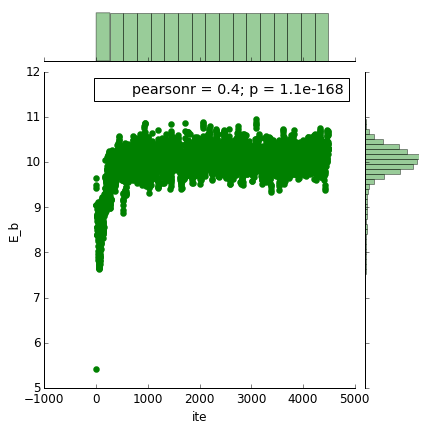

In [13]:
sns.jointplot(x=df['ite'],y=df['E_b'], kind='scatter',color='g',s =20,linewidth=2)
sns.set(style="darkgrid", color_codes=False)

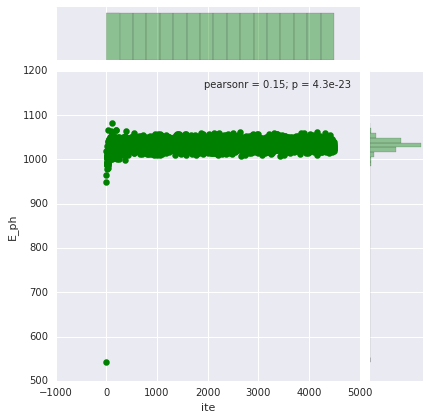

In [14]:
sns.jointplot(x=df['ite'],y=df['E_ph'], kind='scatter',color='g',s =20,linewidth=2)

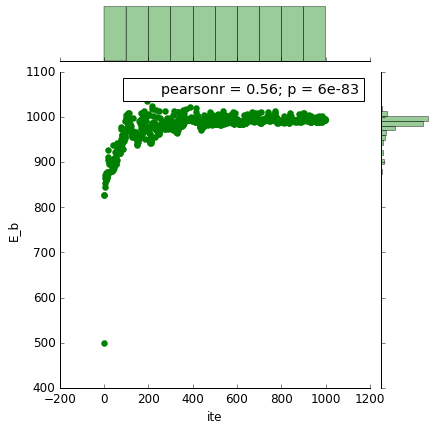

In [27]:
sns.jointplot(x=df['ite'],y=df['E_b'], kind='scatter',color='g',s =20,linewidth=2)
sns.set(style="darkgrid", color_codes=False)

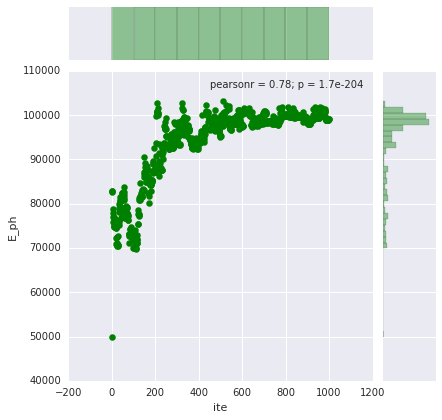

In [28]:
sns.jointplot(x=df['ite'],y=df['E_ph'], kind='scatter',color='g',s =20,linewidth=2)

In [15]:
n, bins, patches = plt.hist(out[0]['E_b'], 50, facecolor='blue')
plt.axvline(1000, color='r')

NameError: name 'out' is not defined

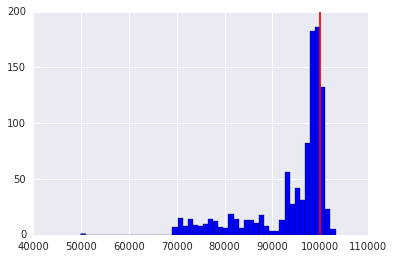

In [30]:
n, bins, patches = plt.hist(out[0]['E_ph'], 50, facecolor='blue')
plt.axvline(1e+5, color='r')

In [31]:
step = 0.01
partitions = [i*step for i in range(round(400./step))]
t = partitions

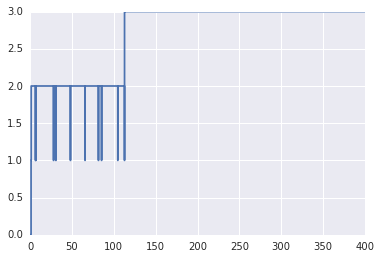

In [32]:
plt.step(x=t[:-1],y=Sn.iloc[0,:])

In [33]:
out1 = out[2] 
pi_true = np.array([[9.95012479e-01, 4.72285706e-03, 2.40596046e-04, 2.40677016e-05],
                    [0.00000000e+00, 8.95880600e-01, 9.46496180e-02, 9.46978182e-03],
                    [0.00000000e+00, 9.46496180e-04, 9.99048684e-01, 4.82001787e-06],
                    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
d = dict([(index,0) for index,v in np.ndenumerate(pi)])
for index, x in np.ndenumerate(pi):
    i = index[0]
    j = index[1]
    d[index] = list(out1.iloc[i::4,j])
    
def plot_hist(dic, pi_true):
    fig = plt.figure(figsize=(16,16)) 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12

    nn = 1
    for i, x in np.ndenumerate(pi_true):
        ax = fig.add_subplot(4,4,nn)
        n, bins, patches = plt.hist(dic[i], 10, facecolor='blue')
        plt.axvline(pi_true[i], color='r')
#         ax.set_title(r'$particle-ID: {}$'.format(str(i)))
#         ax.legend().set_visible(False)
        sns.despine(offset=12,ax=ax,trim=True)
        nn = nn+1

    # plt.subplots_adjust(top=0.92,bottom=0.08,left=0.1,right=0.95,wspace=0.6,hspace=0.6)
    plt.tight_layout()
    plt.show() 
    return None

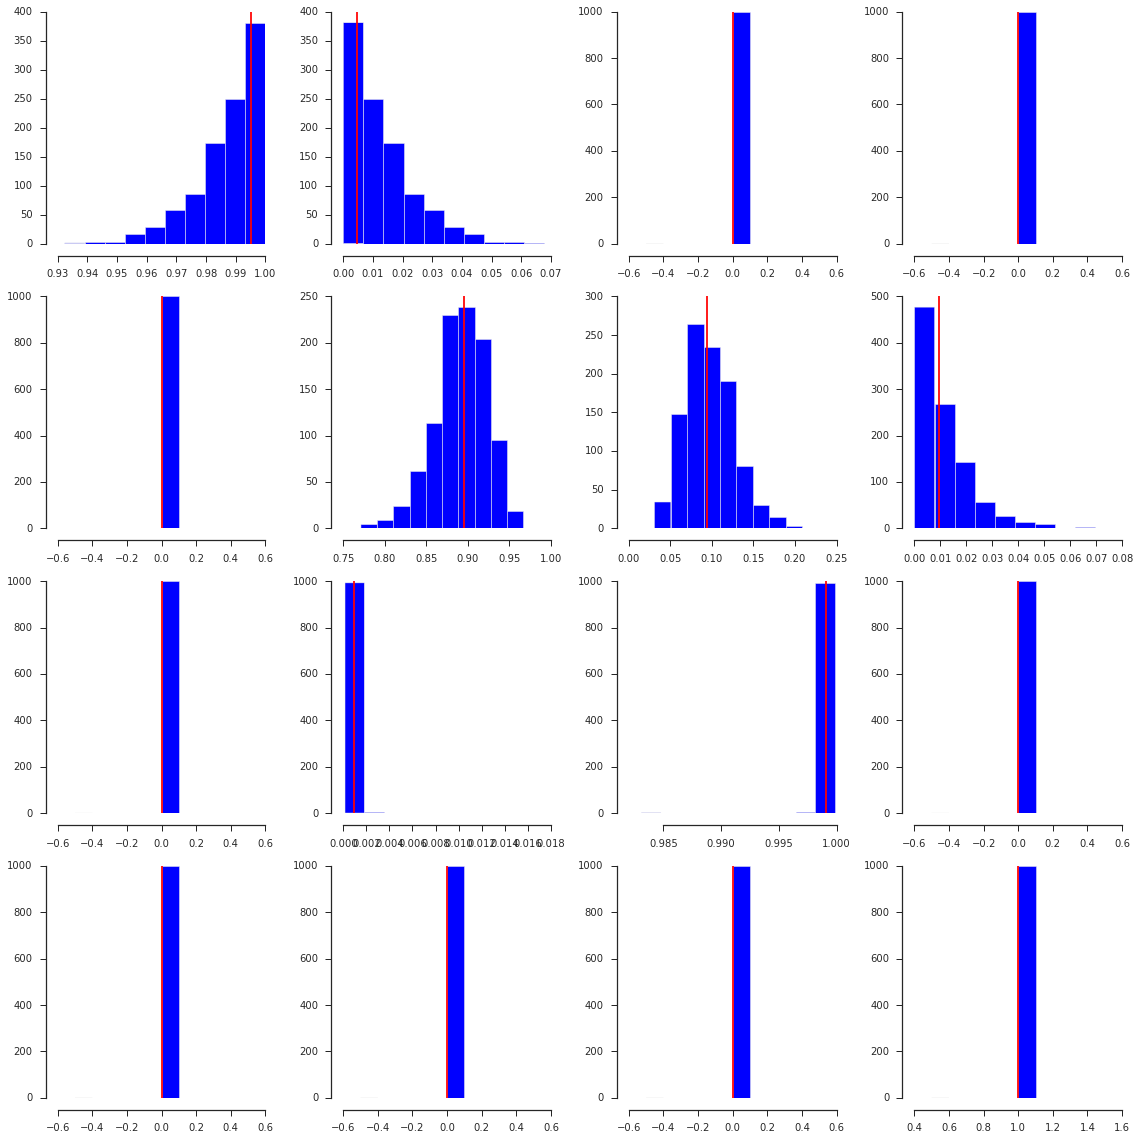

In [34]:
plot_hist(d, pi_true)

In [ ]:
np.sum(np.where(Ksn!=0,True,False))